In [1]:
import sys
if not '../..' in sys.path:
    sys.path.append('../..')
    sys.path.append('..')
from analysis import collection, analysis, emg, plot, model
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import patches, lines
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from joblib import dump, load
from analysis.offsets import offsets

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({'figure.figsize': (16*0.8,9*0.8)})
mpl.rcParams.update({'axes.facecolor': "white"})
mpl.rcParams.update({'lines.marker': "+"})
mpl.rcParams.update({'lines.linestyle': ""})
mpl.rcParams.update({"axes.spines.left":   True})
mpl.rcParams.update({"axes.spines.bottom": True})
mpl.rcParams.update({"axes.spines.top":    False})
mpl.rcParams.update({"axes.spines.right":  False})

image_path = Path("/Users/spencer/phd/phd/images/more_results/gmms/")

%matplotlib inline

In [2]:
subjects = analysis.load_subjects()

In [3]:
import pandas as pd
trajectory_df = pd.read_pickle("../trajectory_dataframe.pkl")
mean_rewards = 1 / trajectory_df.groupby(level=['subject']).mean()["reward"]

In [5]:
model_entropies = []
for subject_idx in range(len(subjects)):
    log_models = model.load_log_trial_models(subject_idx)
    model_entropies.append([model.total_gmm_entropy(m) for m in log_models])

calibration_entropies = []
for subject_idx in range(len(subjects)):
    log_calibration_model = model.load_log_calibration_models(subject_idx)[0]
    calibration_entropies.append(model.total_gmm_entropy(log_calibration_model))

movement_entropies = []
for subject_idx in range(len(subjects)):
    log_movement_model = model.load_log_movement_models(subject_idx)[0]
    movement_entropies.append(model.total_gmm_entropy(log_movement_model))

### higher entropy -- more equiprobable outcomes || lower entropy -- less equiprobable outcomes

goes to negative infinity -- meaning delta function, complete information about the outcome!

Text(0.5, 0, 'Mean Reward')

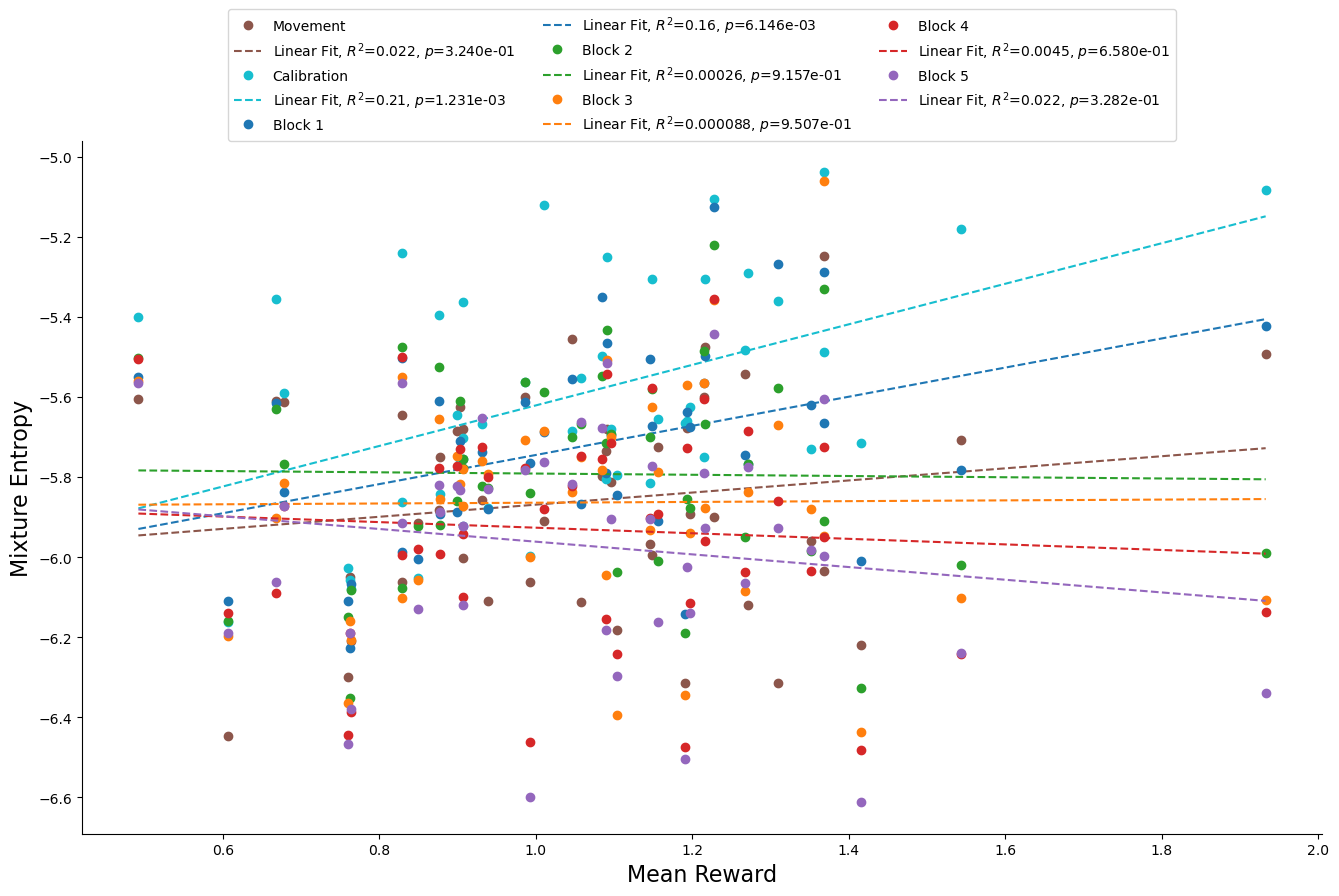

In [6]:
entropy_fig = plt.figure(figsize=(16,9))

plt.plot(mean_rewards,movement_entropies,"o",color="tab:brown",label="Movement")
res = analysis.linear_fit(mean_rewards,movement_entropies)
x = np.linspace(min(mean_rewards),max(mean_rewards),100,endpoint=True)
plot.plot_linear_fit(x,res,plt.gca(),color="tab:brown")

plt.plot(mean_rewards,calibration_entropies,"o",color="tab:cyan",label="Calibration")
res = analysis.linear_fit(mean_rewards,calibration_entropies)
x = np.linspace(min(mean_rewards),max(mean_rewards),100,endpoint=True)
plot.plot_linear_fit(x,res,plt.gca(),color="tab:cyan")

c = ["tab:blue","tab:green","tab:orange","tab:red","tab:purple"]
for i in range(5):
    me = [m[i] for m in model_entropies]
    plt.plot(mean_rewards,me,"o",color=c[i],label=f"Block {i+1}")
    res = analysis.linear_fit(mean_rewards,me)
    x = np.linspace(mean_rewards.min(),mean_rewards.max(),100,endpoint=True)
    plot.plot_linear_fit(x,res,plt.gca(),color=c[i])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),fancybox=True, ncol=3)
plt.ylabel("Mixture Entropy")
plt.xlabel("Mean Reward")

In [7]:
plot.save_figure(entropy_fig, "entropy_gmms", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/entropy_gmms.pdf


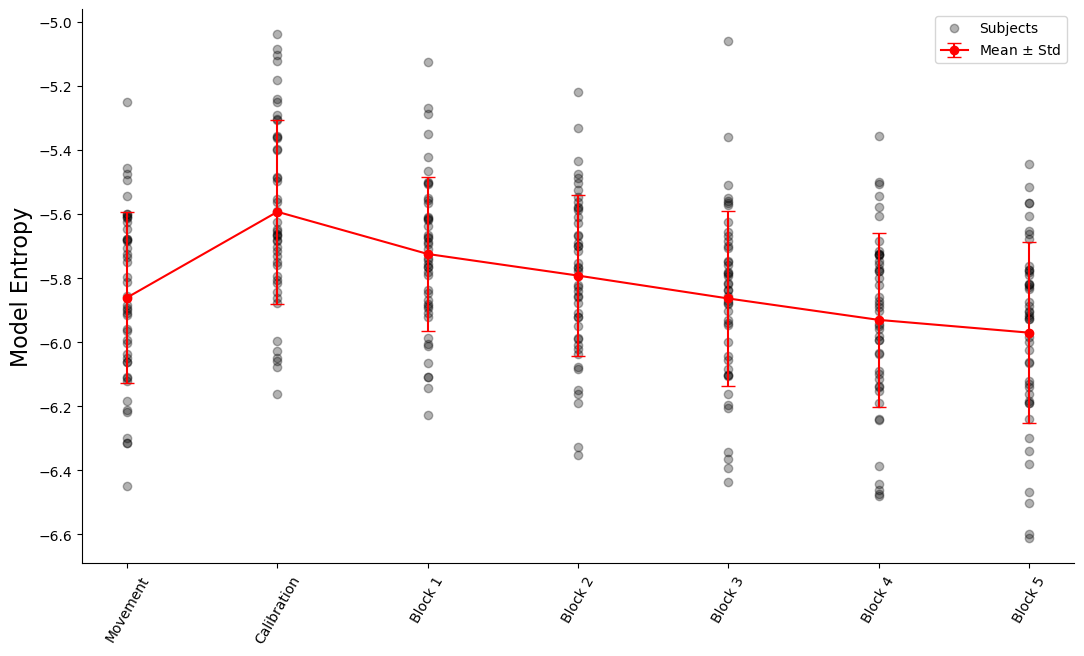

In [8]:
fig = plt.figure()
plt.plot(0*np.ones_like(movement_entropies), movement_entropies,"ko",alpha=0.3,label="Subjects")
plt.errorbar(x=0, y=np.mean(movement_entropies), yerr=np.std(movement_entropies), capsize=5, color="r",linestyle="-",marker="o")
plt.plot(np.ones_like(calibration_entropies), calibration_entropies,"ko",alpha=0.3)
plt.errorbar(x=1, y=np.mean(calibration_entropies), yerr=np.std(calibration_entropies), capsize=5, color="r",linestyle="-",marker="o",label="Mean $\pm$ Std")
for mi, pi in enumerate(range(2,7)):
    me = [m[mi] for m in model_entropies]
    plt.plot(pi*np.ones_like(me),me,"ko",alpha=0.3)
    plt.errorbar(x=pi, y=np.mean(me),yerr=np.std(me),capsize=5,color="r",linestyle="-",marker="o")
plt.plot(range(7),np.concatenate([np.mean(movement_entropies).reshape(1,1),np.mean(calibration_entropies).reshape(1,1),np.mean(np.array(model_entropies),axis=0).reshape(5,1)]),"r-")
plt.legend()
plt.ylabel("Model Entropy")
xlabels = ["Movement", "Calibration", *[f"Block {i+1}" for i in range(5)]]
_ = plt.xticks(range(7),xlabels,rotation=60)

In [9]:
plot.save_figure(fig,"entropy_over_models",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/entropy_over_models.pdf


In [10]:
entropy_stack = np.concatenate([np.array(movement_entropies).reshape(1,-1), np.array(calibration_entropies).reshape(1,-1), np.array(model_entropies).T])
entropy_stack.shape

(7, 46)

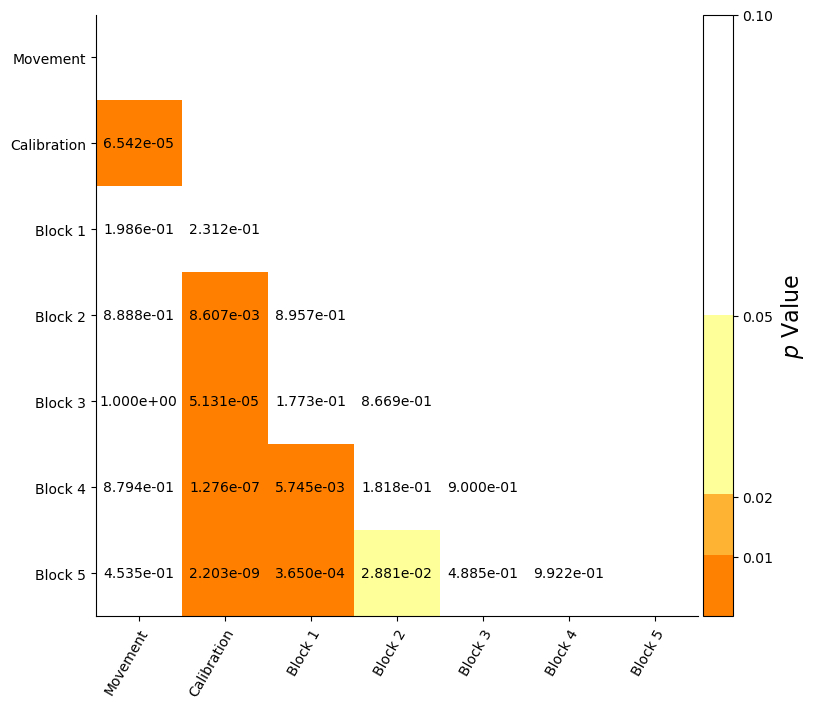

In [11]:
from scipy.stats import tukey_hsd
result = tukey_hsd(*(np.array(entropy_stack)))
entropy_pvalue_fig, _ = plot.annotated_heatmap(result.pvalue,xlabels,xlabels)

In [81]:
plot.save_figure(entropy_pvalue_fig,"model_entropy_pvalues",image_path,format="png")

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/model_entropy_pvalues.png


0.0004607311510688925


Text(0.5, 0, 'Mean Rewards')

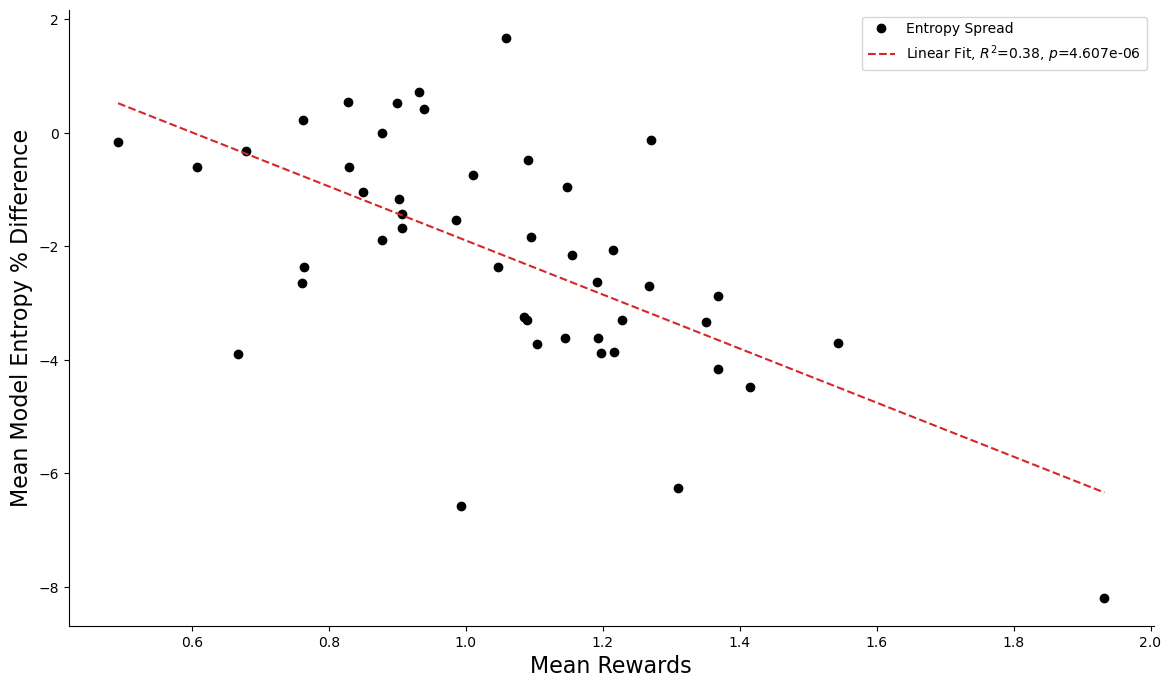

In [82]:
# fig, axes = plt.subplots(2,1,figsize=(13,15))
entropy_diff_fig, ax = plt.subplots(1,1,figsize=(14,8))
axes = [None, ax]
# me = [np.abs(m[0]-m[-1]) for i, m in enumerate(model_entropies) if not i in []]
# xr = [mr for i, mr in enumerate(mean_rewards) if not i in []]
# axes[0].plot(xr,me,"o",color="k",label=f"Entropy Difference")
# res = analysis.linear_fit(xr,me)
# x = np.linspace(mean_rewards.min(),mean_rewards.max(),100,endpoint=True)
# plot.plot_linear_fit(x,res,axes[0])
# axes[0].legend(loc=4)
# axes[0].set_xlabel("Mean Reward")
# axes[0].set_ylabel("Trial Entropy Spread")

entropy_mean_diffs = []
stop_idx = []
for i, e in enumerate(model_entropies):
    if not i in stop_idx:
        e = np.array(e)
        # percent difference -- (x2 - x1)/x1
        entropy_mean_diffs.append(100*np.mean([(e[i+1]-e[i])/np.abs(e[i]) for i in range(4)]))
        # entropy_mean_diffs.append(np.mean([(e[i+1]-e[i])/np.abs(e[i]) for i in range(e.shape[0]-1)]))
rewards = np.array([m for i, m in enumerate(mean_rewards) if not i in stop_idx])
axes[1].plot(rewards, entropy_mean_diffs, 'ko',label=f"Entropy Spread")
res = analysis.linear_fit(rewards,entropy_mean_diffs)
x = np.linspace(rewards.min(),rewards.max(),100,endpoint=True)
plot.plot_linear_fit(x,res,axes[1])
axes[1].legend()
print(res.pvalue*100)
axes[1].set_ylabel("Mean Model Entropy % Difference")
axes[1].set_xlabel("Mean Rewards")

In [83]:
plot.save_figure(entropy_diff_fig, "entropy_diffs", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/entropy_diffs.pdf


# total variance!

In [110]:
def total_gaussian_variance(cov):
    assert cov.shape == (64,64)
    return np.trace(cov)

def total_gmm_variance(m):
    assert len(m.covariances_) > 0
    return np.sum([total_gaussian_variance(c)*w for c, w in zip(m.covariances_,m.weights_)])

In [111]:
model_total_variances = []
for subject_idx in range(len(subjects)):
    log_models = model.load_log_trial_models(subject_idx)
    model_total_variances.append([total_gmm_variance(m) for m in log_models])

calibration_total_variances = []
for subject_idx in range(len(subjects)):
    log_calibration_model = model.load_log_calibration_models(subject_idx)[0]
    calibration_total_variances.append(total_gmm_variance(log_calibration_model))

movement_total_variances = []
for subject_idx in range(len(subjects)):
    log_movement_model = model.load_log_movement_models(subject_idx)[0]
    movement_total_variances.append(total_gmm_variance(log_movement_model))

Text(0.5, 0, 'Mean Reward')

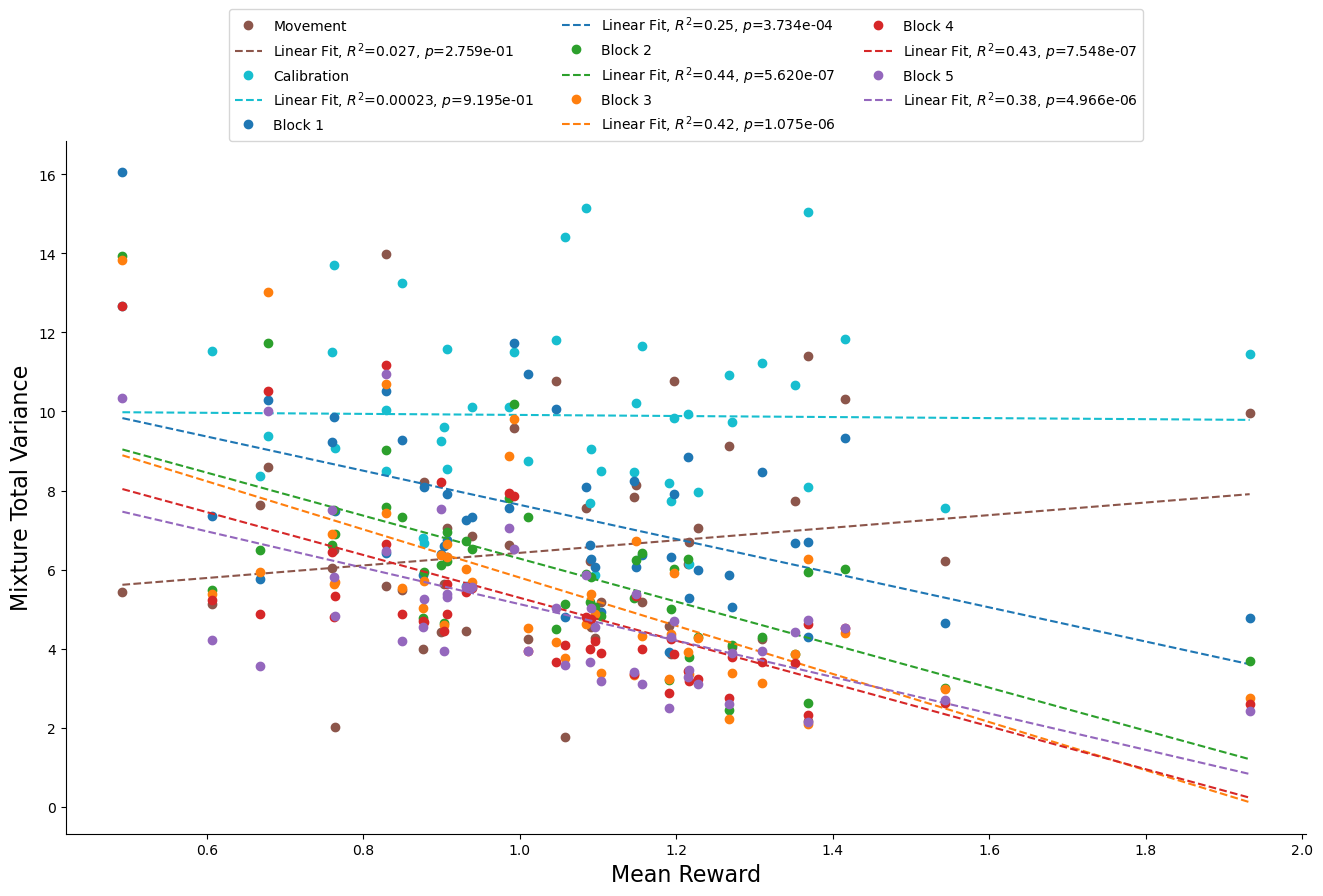

In [112]:
fig = plt.figure(figsize=(16,9))

plt.plot(mean_rewards,movement_total_variances,"o",color="tab:brown",label="Movement")
res = analysis.linear_fit(mean_rewards,movement_total_variances)
x = np.linspace(min(mean_rewards),max(mean_rewards),100,endpoint=True)
plot.plot_linear_fit(x,res,plt.gca(),color="tab:brown")

plt.plot(mean_rewards,calibration_total_variances,"o",color="tab:cyan",label="Calibration")
res = analysis.linear_fit(mean_rewards,calibration_total_variances)
x = np.linspace(min(mean_rewards),max(mean_rewards),100,endpoint=True)
plot.plot_linear_fit(x,res,plt.gca(),color="tab:cyan")

c = ["tab:blue","tab:green","tab:orange","tab:red","tab:purple"]
for i in range(5):
    me = [m[i] for m in model_total_variances]
    plt.plot(mean_rewards,me,"o",color=c[i],label=f"Block {i+1}")
    res = analysis.linear_fit(mean_rewards,me)
    x = np.linspace(mean_rewards.min(),mean_rewards.max(),100,endpoint=True)
    plot.plot_linear_fit(x,res,plt.gca(),color=c[i])

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2),fancybox=True, ncol=3)
plt.ylabel("Mixture Total Variance")
plt.xlabel("Mean Reward")

In [113]:
plot.save_figure(fig, "total_variance_gmms", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/total_variance_gmms.pdf


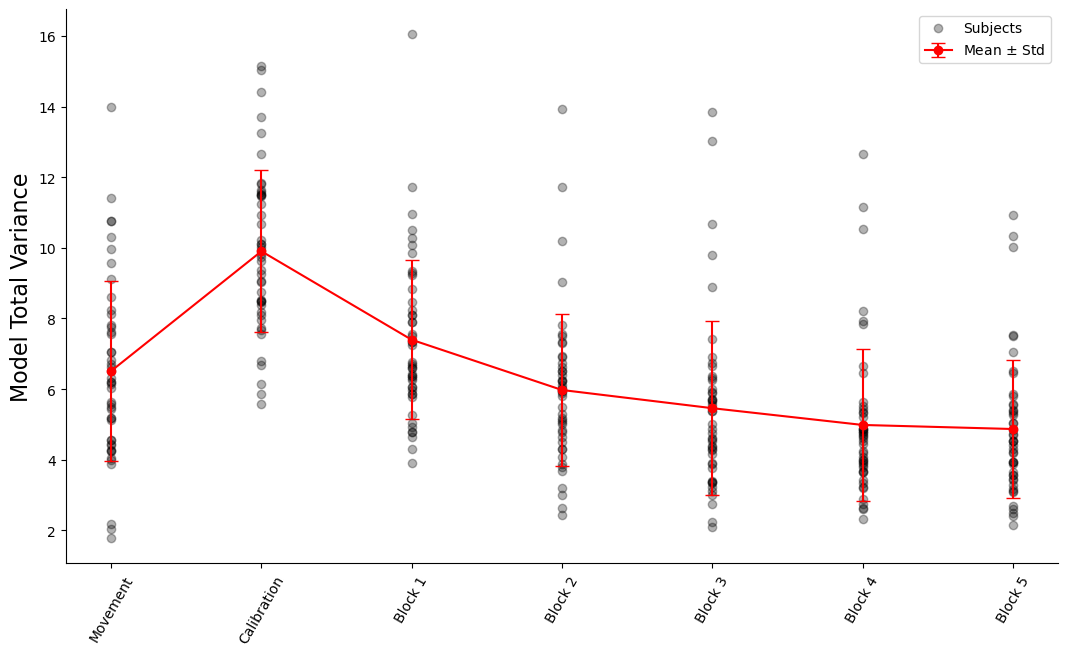

In [114]:
fig = plt.figure()
plt.plot(0*np.ones_like(movement_total_variances), movement_total_variances,"ko",alpha=0.3,label="Subjects")
plt.errorbar(x=0, y=np.mean(movement_total_variances), yerr=np.std(movement_total_variances), capsize=5, color="r",linestyle="-",marker="o")
plt.plot(np.ones_like(calibration_total_variances), calibration_total_variances,"ko",alpha=0.3)
plt.errorbar(x=1, y=np.mean(calibration_total_variances), yerr=np.std(calibration_total_variances), capsize=5, color="r",linestyle="-",marker="o",label="Mean $\pm$ Std")
for mi, pi in enumerate(range(2,7)):
    me = [m[mi] for m in model_total_variances]
    plt.plot(pi*np.ones_like(me),me,"ko",alpha=0.3)
    plt.errorbar(x=pi, y=np.mean(me),yerr=np.std(me),capsize=5,color="r",linestyle="-",marker="o")
plt.plot(range(7),np.concatenate([np.mean(movement_total_variances).reshape(1,1),np.mean(calibration_total_variances).reshape(1,1),np.mean(np.array(model_total_variances),axis=0).reshape(5,1)]),"r-")
plt.legend()
plt.ylabel("Model Total Variance")
xlabels = ["Movement", "Calibration", *[f"Block {i+1}" for i in range(5)]]
_ = plt.xticks(range(7),xlabels,rotation=60)

In [115]:
plot.save_figure(fig,"total_variance_over_models",image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/total_variance_over_models.pdf


In [116]:
total_entropy_stack = np.concatenate([np.array(movement_total_variances).reshape(1,-1), np.array(calibration_total_variances).reshape(1,-1), np.array(model_total_variances).T])
total_entropy_stack.shape

(7, 46)

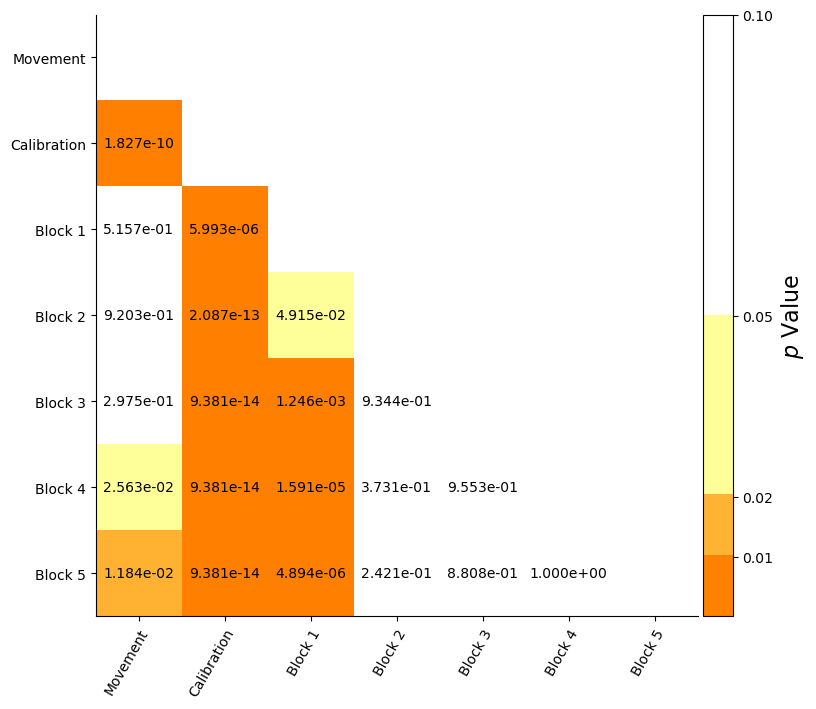

In [117]:
from scipy.stats import tukey_hsd
result = tukey_hsd(*(np.array(total_entropy_stack)))
fig, _ = plot.annotated_heatmap(result.pvalue,xlabels,xlabels)

In [118]:
plot.save_figure(fig,"model_total_variance_pvalues",image_path,format="png")

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/model_total_variance_pvalues.png


Text(0.5, 0, 'Mean Rewards')

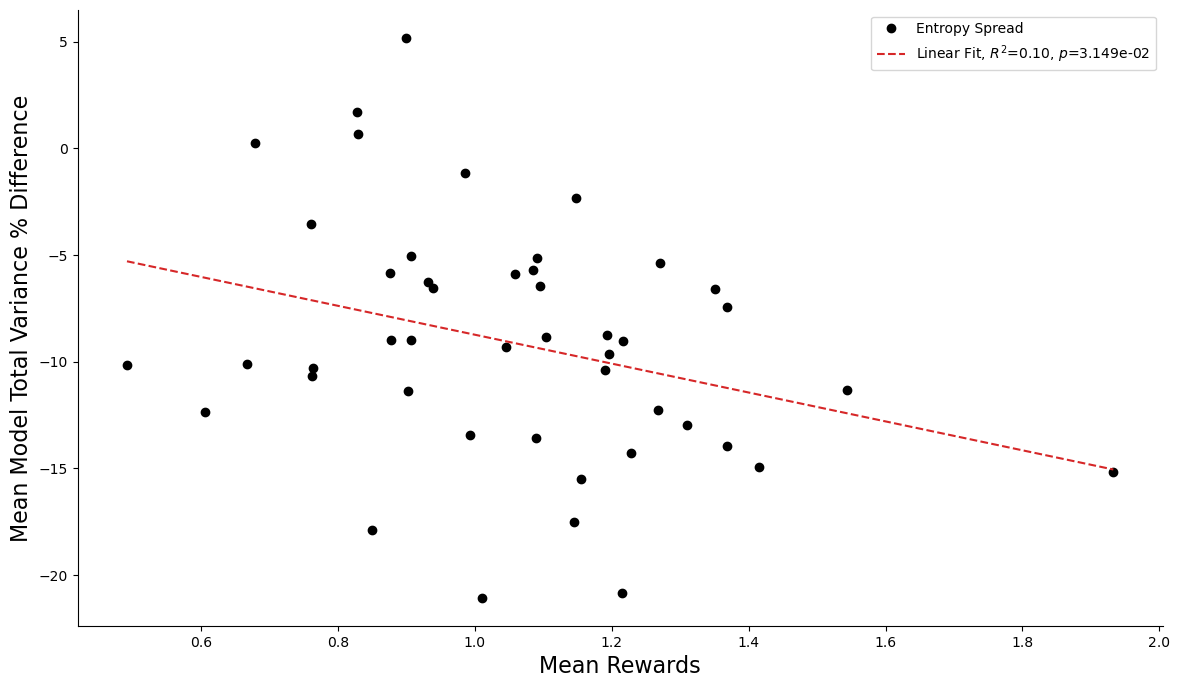

In [119]:
fig, ax = plt.subplots(1,1,figsize=(14,8))
axes = [None, ax]

total_variance_mean_diffs = []
stop_idx = []
for i, e in enumerate(model_entropies):
    if not i in stop_idx:
        e = np.array(e)
        # percent difference -- (x2 - x1)/x1
        total_variance_mean_diffs.append(100*np.mean([(e[i+1]-e[i])/np.abs(e[i]) for i in range(4)]))
        # total_variance_mean_diffs.append(np.mean([(e[i+1]-e[i])/np.abs(e[i]) for i in range(e.shape[0]-1)]))
rewards = np.array([m for i, m in enumerate(mean_rewards) if not i in stop_idx])
axes[1].plot(rewards, total_variance_mean_diffs, 'ko',label=f"Entropy Spread")
res = analysis.linear_fit(rewards,total_variance_mean_diffs)
x = np.linspace(rewards.min(),rewards.max(),100,endpoint=True)
plot.plot_linear_fit(x,res,axes[1])
axes[1].legend()
axes[1].set_ylabel("Mean Model Total Variance % Difference")
axes[1].set_xlabel("Mean Rewards")

In [120]:
plot.save_figure(fig, "total_variance_diffs", image_path)

Figure saved to /Users/spencer/phd/phd/images/more_results/gmms/total_variance_diffs.pdf


# blah

0.02044883009227504


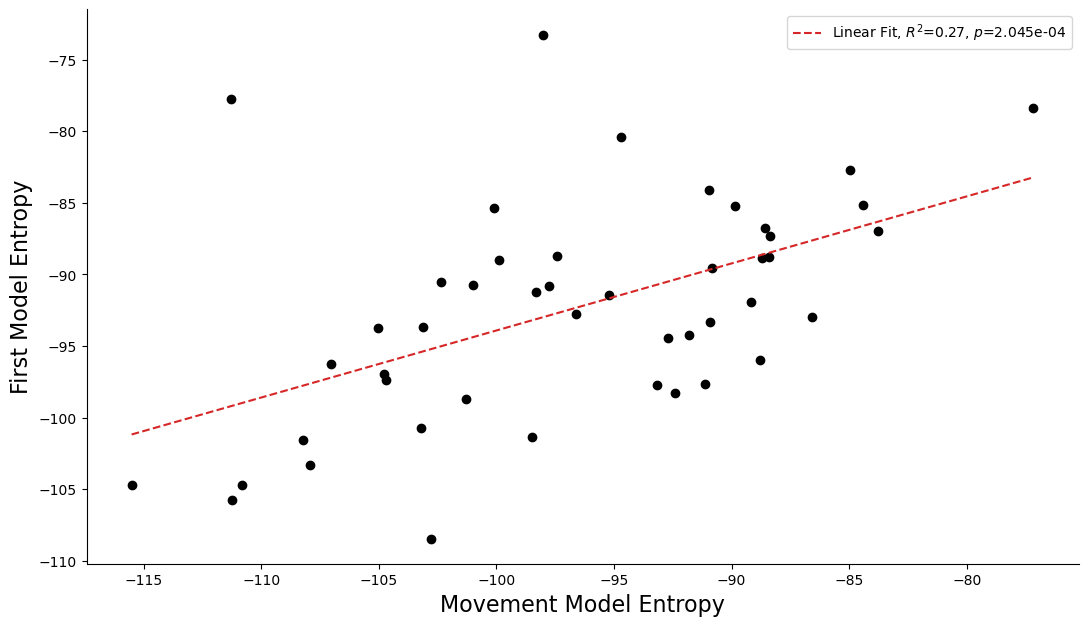

In [50]:
plt.figure()
first_model_entropies = [m[0] for m in model_entropies]
plt.plot(movement_entropies,first_model_entropies,"ko")
res = analysis.linear_fit(movement_entropies,first_model_entropies)
x = np.linspace(min(movement_entropies),max(movement_entropies),100,endpoint=True)
plot.plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("First Model Entropy")
plt.xlabel("Movement Model Entropy")
print(res.pvalue*100)

2.9387395365551612e-06


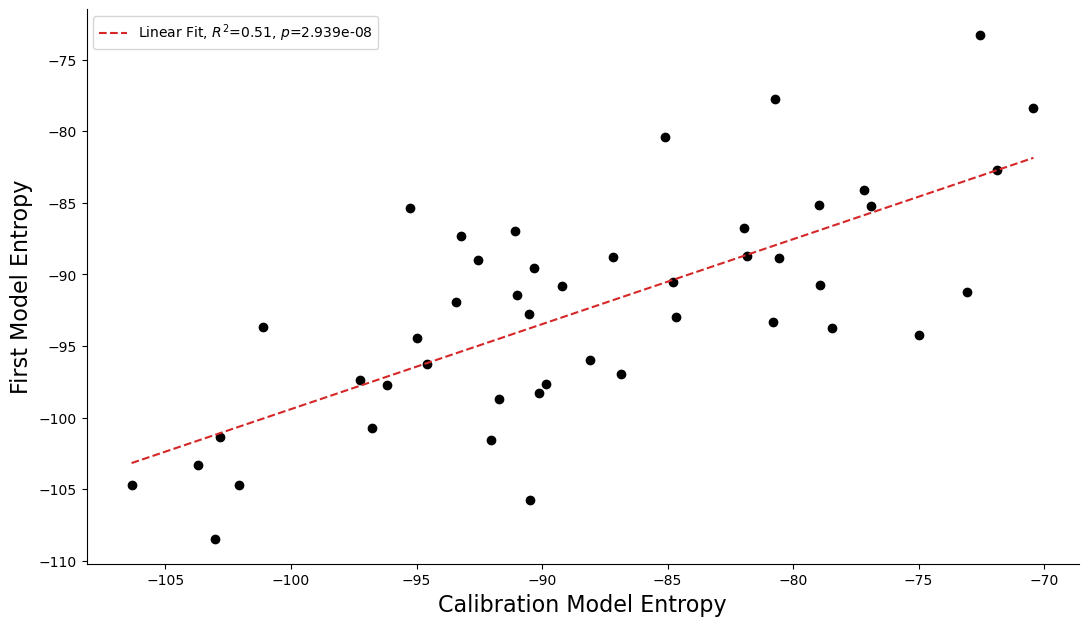

In [51]:
plt.figure()
first_model_entropies = [m[0] for m in model_entropies]
plt.plot(calibration_entropies,first_model_entropies,"ko")
res = analysis.linear_fit(calibration_entropies,first_model_entropies)
x = np.linspace(min(calibration_entropies),max(calibration_entropies),100,endpoint=True)
plot.plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("First Model Entropy")
plt.xlabel("Calibration Model Entropy")
print(res.pvalue*100)

0.048198025369248595


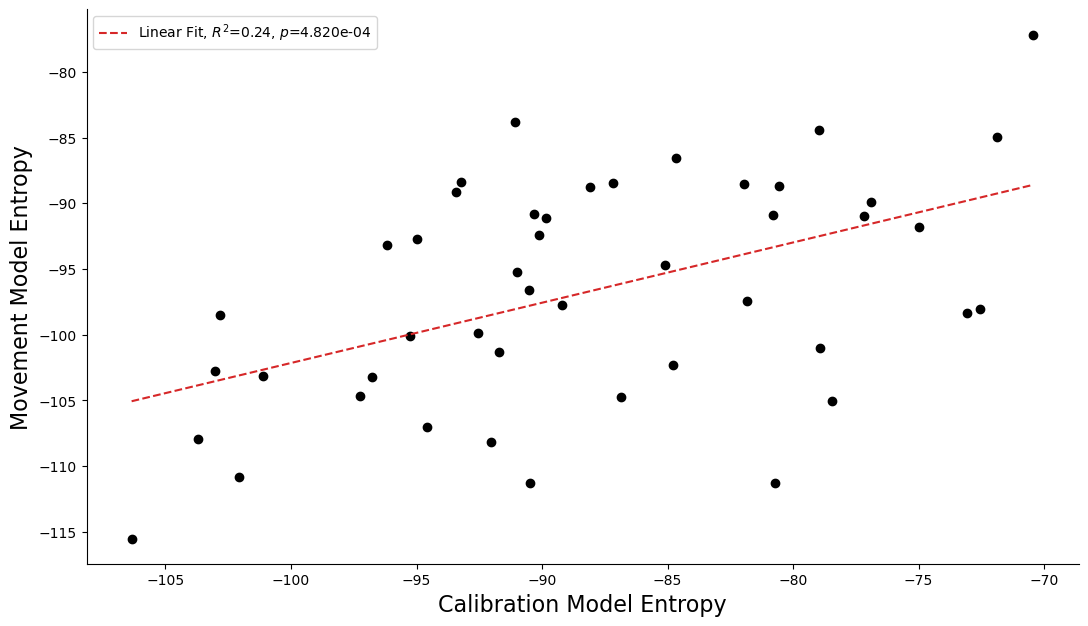

In [52]:
plt.figure()
plt.plot(calibration_entropies,movement_entropies,"ko")
res = analysis.linear_fit(calibration_entropies,movement_entropies)
x = np.linspace(min(calibration_entropies),max(calibration_entropies),100,endpoint=True)
plot.plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("Movement Model Entropy")
plt.xlabel("Calibration Model Entropy")
print(res.pvalue*100)

0.00031846221219614503


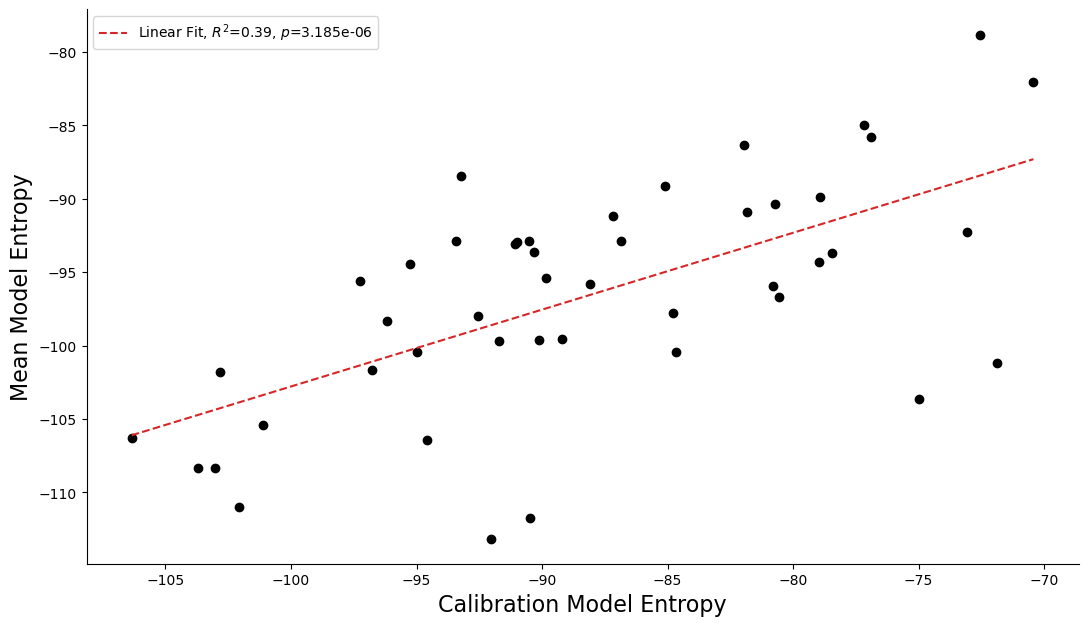

In [53]:
plt.figure()
first_model_entropies = [np.mean(m) for m in model_entropies]
plt.plot(calibration_entropies,first_model_entropies,"ko")
res = analysis.linear_fit(calibration_entropies,first_model_entropies)
x = np.linspace(min(calibration_entropies),max(calibration_entropies),100,endpoint=True)
plot.plot_linear_fit(x,res,plt.gca())
plt.legend()
plt.ylabel("Mean Model Entropy")
plt.xlabel("Calibration Model Entropy")
print(res.pvalue*100)